## Setup & Installation

In [1]:
%%writefile requirements.txt
diffusers==0.11.1
pyre-extensions==0.0.23
ninja # make builds faster
xformers==0.0.16rc425
triton==2.0.0.dev20221120
transformers==4.25.1
accelerate==0.15.0

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt --upgrade

In [ ]:
!python -m xformers.info

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

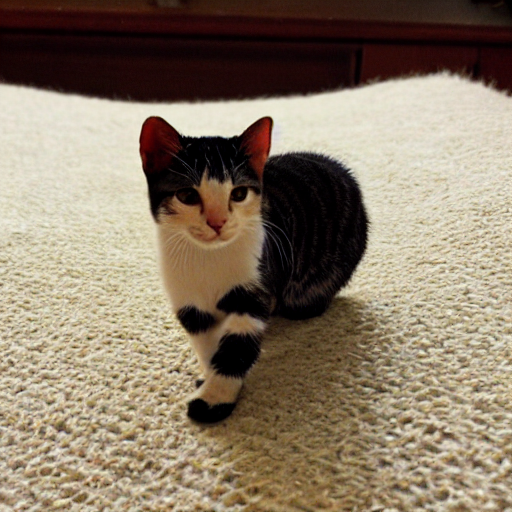

In [4]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

# enable memory efficient attention
pipe.enable_xformers_memory_efficient_attention()

# change scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)


with torch.inference_mode():
    sample = pipe("a small cat")
    
sample.images[0]

## Benchmark 




In [5]:
from time import perf_counter
import numpy as np


def measure_latency(pipe, prompt):
    latencies = []
    # warm up
    pipe.set_progress_bar_config(disable=True)
    for _ in range(2):
        _ =  pipe(prompt)
    # Timed run
    for _ in range(10):
        start_time = perf_counter()
        _ = pipe(prompt,   
                num_inference_steps=25,
                guidance_scale=7.5,
                num_images_per_prompt=1,
                )
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_s = np.mean(latencies)
    time_std_s = np.std(latencies)
    time_p95_s = np.percentile(latencies,95)
    return f"P95 latency (seconds) - {time_p95_s:.2f}; Average latency (seconds) - {time_avg_s:.2f} +\- {time_std_s:.2f};", time_p95_s


prompt = "a photo of an astronaut riding a horse on mars"

vanilla_results = measure_latency(pipe, prompt)

print(f"Vanilla pipeline: {vanilla_results[0]}")


Vanilla pipeline: P95 latency (seconds) - 1.58; Average latency (seconds) - 1.55 +\- 0.02;


## Uninstall all

In [ ]:
!pip uninstall diffusers pyre-extensions ninja xformers triton transformers accelerate -y